In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam 
from keras.utils import np_utils
import glob         #ファイル読み込みに使用
import sys
import numpy as np
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph

In [3]:
import shutil
import os

In [4]:
# Hyper Parameter
BATCH_SIZE   = 32
NUM_CLASSES  = 10
EPOCHS       = 5
class_name   = ['AMD','RVO','Gla','MH','DR','RD','RP','AO','DM','HE']

#imgsize
IMG_ROWS     = 768
IMG_COLS     = 1024
IMG_CHANNELS = 3

#Input File
csv_filename = "data.csv"
image_folder = "./img"

#Output File
best_model_path = 'best_model_path_dp.h5'
final_model_path = 'final_model_path_dp.h5'
output_file = 'model.summary_dp.txt'

In [5]:
import pandas as pd
df=pd.read_csv(csv_filename)
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0


In [6]:
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [7]:
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE
0,000000_00.jpg,3090,78,M,L,0,0,0,0,0,0,0,0,0,0,1
1,000000_01.jpg,3090,78,M,R,0,0,0,0,0,0,0,0,0,0,1
2,000001_00.jpg,2702,76,F,L,0,0,0,0,0,0,0,0,0,0,1
3,000001_01.jpg,2702,76,F,R,0,0,0,0,0,0,0,0,0,0,1
4,000001_02.jpg,1136,69,M,L,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13042,005387_01.jpg,3657,73,F,L,0,0,0,0,0,0,0,0,0,0,1
13043,005387_02.jpg,173,73,F,R,0,0,0,0,0,0,0,0,0,0,1
13044,005387_03.jpg,3156,71,F,R,0,0,0,0,0,0,0,0,0,0,1
13045,005388_00.jpg,3156,71,F,L,0,0,0,0,0,0,0,0,0,0,1


In [8]:
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [9]:
#load the training data
img_height=256
img_width=256
batch_size=16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate/train',
  validation_split=0.25,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8247 files belonging to 3 classes.
Using 6186 files for training.


2022-11-29 01:03:26.547404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#load the validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate/train',
  validation_split=0.25,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8247 files belonging to 3 classes.
Using 2061 files for validation.


In [11]:
#load the test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate/test',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 2059 files belonging to 3 classes.


In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [13]:
#build the resnet model
model = ResNet50(include_top=False, input_shape=(img_height, img_width, 3))
flat1 = Flatten()(model.output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(3, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
#train the model
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
387/387 [==============================] - 1869s 5s/step - loss: 1.3502 - accuracy: 0.6806 - val_loss: 0.6551 - val_accuracy: 0.7263
Epoch 2/10
387/387 [==============================] - 1858s 5s/step - loss: 0.5294 - accuracy: 0.7934 - val_loss: 0.9478 - val_accuracy: 0.6060
Epoch 3/10
387/387 [==============================] - 1859s 5s/step - loss: 0.3772 - accuracy: 0.8548 - val_loss: 0.8375 - val_accuracy: 0.7341
Epoch 4/10
387/387 [==============================] - 1858s 5s/step - loss: 0.2653 - accuracy: 0.8962 - val_loss: 0.7365 - val_accuracy: 0.7642
Epoch 5/10
387/387 [==============================] - 1858s 5s/step - loss: 0.1661 - accuracy: 0.9384 - val_loss: 1.1131 - val_accuracy: 0.7627
Epoch 6/10
387/387 [==============================] - 1857s 5s/step - loss: 0.1275 - accuracy: 0.9505 - val_loss: 0.9224 - val_accuracy: 0.7608
Epoch 7/10
387/387 [==============================] - 1858s 5s/step - loss: 0.0945 - accuracy: 0.9673 - val_loss: 0.7429 - val_accuracy:

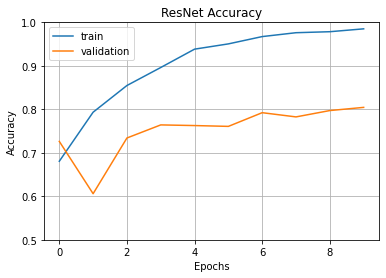

In [3]:
# plot the trend of training and validation accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.5,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#predict the test data
df_p=pd.DataFrame(model.predict(test_ds))
df_p

129/129 [==============================] - 154s 1s/step


,0,1,2
0,0.999997,2.987863e-06,1.344935e-08
1,1.000000,1.540510e-08,7.363827e-12
2,0.999912,9.119727e-06,7.914924e-05
3,0.999325,6.753983e-04,1.471552e-08
4,0.634135,2.307235e-05,3.658421e-01
...,...,...,...
2054,0.009377,9.897949e-01,8.285822e-04
2055,0.004212,4.751430e-03,9.910367e-01
2056,0.040590,2.304654e-04,9.591792e-01
2057,0.197617,3.518137e-03,7.988647e-01


In [17]:
#add the original label as the last column in the dataframe
test_label = np.concatenate([y for x, y in test_ds], axis=0) 
df_l=pd.DataFrame(test_label)
df_l
pd.concat([df_p,df_l],axis=1)

,0,1,2,0
0,0.999997,2.987863e-06,1.344935e-08,0
1,1.000000,1.540510e-08,7.363827e-12,0
2,0.999912,9.119727e-06,7.914924e-05,0
3,0.999325,6.753983e-04,1.471552e-08,0
4,0.634135,2.307235e-05,3.658421e-01,0
...,...,...,...,...
2054,0.009377,9.897949e-01,8.285822e-04,2
2055,0.004212,4.751430e-03,9.910367e-01,2
2056,0.040590,2.304654e-04,9.591792e-01,2
2057,0.197617,3.518137e-03,7.988647e-01,2


In [18]:
#evaluate the model
model.evaluate(test_ds)

129/129 [==============================] - 145s 1s/step - loss: 0.8777 - accuracy: 0.8009


[0.8777125477790833, 0.8008742332458496]